# Quick Start: EMRI Signal Search with JAX

This Jupyter Notebook demonstrates a simplified search for an Extreme Mass Ratio Inspiral (EMRI) signal using JAX for high-performance computation. The goal is to detect the frequency evolution of an EMRI signal in simulated Short Fourier Transform (SFT) data. To reduce computational cost, we use a smaller batch size and fewer optimization steps, and we limit the search to a single plunge time (`Tpl`). The notebook uses differential evolution and Adam optimization to find the best-fitting frequency track.

## Steps
1. **Set Parameters**: Define EMRI parameters (masses, spin, plunge time, etc.).
2. **Generate Signal**: Create simulated EMRI signal and SFT data.
3. **Search**: Use differential evolution and Adam optimization to find the best frequency track.
4. **Visualize**: Plot the results to compare the true and optimized frequency tracks.

In [1]:
import time
import os
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import numpy as np
from few.utils.constants import YRSID_SI
from jax_utils import psd, det_stat
from jax_de_utils import differential_evolution_step, selection
from search_utils import generate_emri_signal_and_sfts
from draw_population import ParameterScaler, to_unit_cube, from_unit_cube
from tqdm import trange
from search_utils import det_stat as det_stat_evolution

# Define log-likelihood function
def _loglike(f_alpha, fdot_alpha, data_sfts, T_sft=5e4):
    ll = det_stat(data_sfts, f_alpha, fdot_alpha, T_sft=T_sft)
    return ll

# Roll and zero function for frequency tracks
def roll_and_zero(f_alpha_new, shift):
    rolled = jnp.roll(f_alpha_new, shift, axis=0)
    indices = jnp.arange(len(f_alpha_new))
    mask_pos = jnp.where(shift > 0, indices < shift, False)
    mask_neg = jnp.where(shift < 0, indices >= (len(f_alpha_new) + shift), False)
    zero_mask = mask_pos | mask_neg
    return jnp.where(zero_mask, 0.0, rolled)

# Negative log-likelihood for optimization
def _neg_loglike_alphas(xi, shift, data_sfts, noise_sfts, t_alpha, V_K, lower, upper, T_sft=5e4):
    u = from_unit_cube(xi, lower, upper)
    f_alpha = u @ V_K
    f_alpha_new = roll_and_zero(f_alpha, shift)[:len(t_alpha)]
    fdot_alpha = jnp.gradient(f_alpha_new, t_alpha)
    return -_loglike(f_alpha_new, fdot_alpha, data_sfts, T_sft=T_sft)

# Vectorized negative log-likelihood
neg_loglike_alphas = jax.jit(
    jax.vmap(
        _neg_loglike_alphas, 
        in_axes=(0, 0, None, None, None, None, None, None),
        out_axes=0,
    ),
)

Using TDI PSD
Using TDI PSD


## Step 1: Set Parameters

Define the EMRI parameters and search settings. To reduce computational cost, we search for a single plunge time (`Tpl`) and use a smaller batch size.

In [2]:
# EMRI and search parameters
m1 = 1e6  # Primary mass (solar masses)
m2 = 10.0  # Secondary mass (solar masses)
a = 0.9  # Spin parameter
Tpl = 1.0  # Plunge time (years)
ef = 0.05  # Final eccentricity
T_sft = 5e4  # SFT duration (seconds)
T_data = 1.0  # Total data duration (years)
deltaT = 5.0  # Time step (seconds)
snr_ref = 30.0  # Reference SNR
T_snr = 1.0  # SNR duration (years)
seed = 2601  # Random seed
nsteps = 100  # Number of optimization steps (reduced for quick start)
batch_size = 64  # Initial batch size (reduced for quick start)
opt_batch_size = 32  # Optimization batch size (reduced for quick start)
output_dir = './quick_start_results'  # Output directory
os.makedirs(output_dir, exist_ok=True)
np.random.seed(seed)

## Step 2: Generate EMRI Signal and SFTs

Generate the simulated EMRI signal and Short Fourier Transforms (SFTs) using the provided utility function.

In [3]:
true_values = np.array([m1, m2, a, Tpl, ef, 1.0])
injection_dict = generate_emri_signal_and_sfts(true_values, T_data, T_sft, deltaT, snr_ref, T_snr)
t_alpha = injection_dict['t_alpha']
phi, f_phi_r, dotf, dotdotf = injection_dict['true_phi_f_fdot_fddot']
samples_per_sft = injection_dict['samples_per_sft']
data_sfts = jnp.asarray(injection_dict['data_sfts'], dtype=jnp.complex128)
noise_sfts = jnp.asarray(injection_dict['noise_sfts'], dtype=jnp.complex128)
signal_sfts = jnp.asarray(injection_dict['signal_sfts'], dtype=jnp.complex128)

Using response generator
Waveform generated on CPU
Final SNR: 30.0


## Step 3: Plot True Frequency Track

Visualize the true frequency track in the SFT data for the harmonic (m=2, n=0).

Log-likelihood ratio: -1148.6466129561397
Log-likelihood ratio: -1127.3455163982178
Log-likelihood ratio: -1299.6219838802888


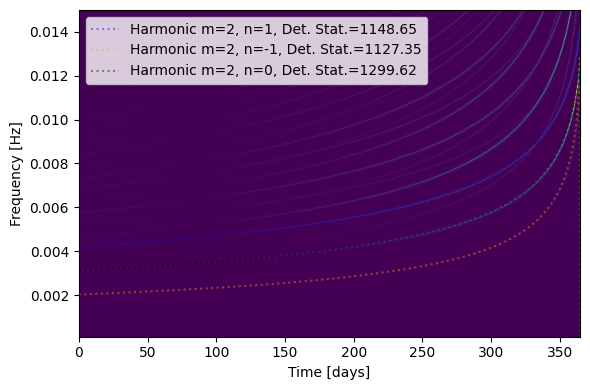

In [ ]:
frequencies = np.fft.rfftfreq(samples_per_sft, deltaT)
plt.figure(figsize=(6,4))
plt.imshow(np.abs(injection_dict['signal_sfts']),aspect='auto',origin='lower',extent=[0, t_alpha[-1]/86400, frequencies[0], frequencies[-1]],cmap='viridis')
plt.ylim(1e-4, 0.015)
for m,n,col in [(2,1,"blue"), (2,-1,"orange"), (2,0,"black")]:
    f_alpha = jnp.asarray(m*f_phi_r[0] + n*f_phi_r[1], dtype=jnp.float64)
    fdot_alpha = jnp.asarray(m*dotf[0] + n*dotf[1], dtype=jnp.float64)
    ll_d = det_stat(injection_dict['data_sfts'], f_alpha, fdot_alpha, T_sft=T_sft)
    ll_h = det_stat(injection_dict['signal_sfts'], f_alpha, fdot_alpha, T_sft=T_sft)
    ll_n = det_stat(injection_dict['noise_sfts'], f_alpha, fdot_alpha, T_sft=T_sft)
    ll_new = det_stat(injection_dict['new_noise_sfts'], f_alpha, fdot_alpha, T_sft=T_sft)
    nll_true =  - ll_d
    print(f"Log-likelihood ratio: {nll_true}")
    plt.plot(t_alpha/86400, f_alpha, ':', label=f'Harmonic m={m}, n={n}, Det. Stat.={-nll_true:.2f}', alpha=0.4, color=col)

plt.legend(loc='upper left')
plt.xlabel('Time [days]')
plt.ylabel('Frequency [Hz]')
plt.tight_layout()
plt.savefig(output_dir + '/true_frequency_track.png', dpi=300)

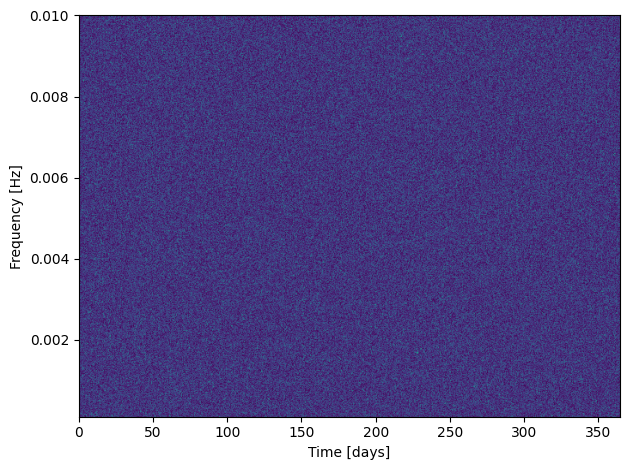

In [ ]:
toplot = np.array(data_sfts) / np.array(psd(frequencies))[:,None]**0.5

plt.figure()
plt.imshow(np.abs(toplot), aspect='auto', origin='lower',
           extent=[0, t_alpha[-1]/86400, frequencies[0], frequencies[-1]], cmap='viridis')
plt.ylim(1e-4, 0.01)
plt.xlabel('Time [days]')
plt.ylabel('Frequency [Hz]')
plt.tight_layout()
plt.show()

## Step 4: Load SVD Basis and Set Bounds

Load the Singular Value Decomposition (SVD) basis for parameter transformation and define optimization bounds.

In [6]:
svd_data = np.load('new_svd_basis_Tsft50000.0_cut20.npz', allow_pickle=True)
V_K = jnp.array(svd_data['V_K'])
lb = svd_data['lb']
ub = svd_data['ub']
default_bounds = np.array([[lb[i], ub[i]] for i in range(svd_data['W'].shape[1])])
lower = jnp.asarray(default_bounds[:, 0])
upper = jnp.asarray(default_bounds[:, 1])
deltaTpl = T_sft / YRSID_SI
default_bounds = np.append(default_bounds, [[Tpl - deltaTpl, Tpl + deltaTpl]], axis=0)

## Step 5: Initialize Population

Generate an initial population of frequency tracks, ensuring positive frequencies.

In [7]:
ps = ParameterScaler(default_bounds, seed=seed)
coords = ps.draw_samples(batch_size)
initial_f_alpha = coords[:, :-1] @ V_K
# Note that we start around the true track for this quick start tutorial, in reality we span: f0_uniform = np.random.uniform(5e-4, 1e-2, size=initial_f_alpha[:, 0].shape[0])
f0_uniform = np.random.uniform(1e-3, 5e-3, size=initial_f_alpha[:, 0].shape[0])
new_initial_f_alpha = initial_f_alpha - initial_f_alpha[:, :1] + f0_uniform[:, None]
coords[:, :-1] = new_initial_f_alpha @ V_K.T
coords = np.asarray([el for el in coords if np.all(el[:-1] @ V_K >= 0.0)])
print(f'Batch size reduced from {batch_size} to {coords.shape[0]} due to positive frequency enforcement')
batch_size = coords.shape[0]
shift = jnp.array((coords[:, -1] - 1.0) * YRSID_SI / T_sft, dtype=jnp.int64)
shift_center = jnp.array((Tpl - 1.0) * YRSID_SI / T_sft, dtype=jnp.int64)
test_many_xis = jnp.array(to_unit_cube(coords[:, :-1], lower, upper))
# we consider only one Tpl shift for the true value
Tpl_vector = np.array([Tpl])
# reals runs use # Tpl_vector = np.arange(0.1, 1.0, 12*deltaTpl)

Batch size reduced from 64 to 64 due to positive frequency enforcement


## Step 6: Optimize Frequency Tracks

Perform optimization using a hybrid of differential evolution and Adam optimization to find the best frequency track.

In [8]:
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key)
grad_fn = jax.jit(jax.value_and_grad(_neg_loglike_alphas))
nll_test = neg_loglike_alphas(test_many_xis[:2], shift[:2], data_sfts, noise_sfts, t_alpha, V_K, lower, upper).block_until_ready()
print('Compiled vectorized function:', nll_test)
out = neg_loglike_alphas(test_many_xis, shift, data_sfts, noise_sfts, t_alpha, V_K, lower, upper).block_until_ready()
ind_argmin = jnp.argmin(out)
print('Initial best log-likelihood:', out[ind_argmin])

# Initialize optimizer
optimizer = optax.adam(learning_rate=1e-5)
batch_xi = test_many_xis[jnp.argsort(out)[:opt_batch_size]]
batch_opt_state = jax.vmap(optimizer.init)(batch_xi)

def update_step(xi, opt_state, *args):
    loss, grads = grad_fn(xi, *args)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_xi = optax.apply_updates(xi, updates)
    new_xi = jnp.clip(new_xi, 0.0, 1.0)
    return new_xi, opt_state, loss, grads

vmapped_update_step = jax.jit(jax.vmap(update_step, in_axes=(0, 0, None, None, None, None, None, None, None), out_axes=0))
static_args = (shift_center, data_sfts, noise_sfts, t_alpha, V_K, lower, upper)

# Optimization loop
progress_bar = trange(nsteps + 1, desc='Optimizing')
optimization_log = {'best_loss': [], 'best_f': [], 'best_x': []}
save_step = 10
save_n_walkers = -1  # Save all walkers

for step in progress_bar:
    batch_xi, batch_opt_state, batch_loss, grads = vmapped_update_step(batch_xi, batch_opt_state, *static_args)

    # Randomly draw DE parameters for each step
    elitism = bool(np.random.choice([True, False], p=[0.5, 0.5]))
    crossover_rate = 1.0 
    differential_weight = np.random.uniform(0.3, 1.5)

    # Transform to f_alpha space
    batch_f = from_unit_cube(batch_xi, lower, upper) @ V_K

    # Perform differential evolution step: x_new = x_r3 (or x_best) + F (x_r1 - x_r2)
    trial_f = differential_evolution_step(subkey, batch_f, fitness=batch_loss, elitism=elitism, 
                                        crossover_rate=crossover_rate, differential_weight=differential_weight)

    # Transform back to xi space
    trial_xi = to_unit_cube(trial_f @ V_K.T, lower, upper)

    # Enforce boundaries
    trial_xi = jnp.clip(trial_xi, 0.0, 1.0)

    # Compute loss for trial population
    trial_fitness = neg_loglike_alphas(trial_xi, jnp.zeros(opt_batch_size) + static_args[0], 
                                    data_sfts, noise_sfts, t_alpha, V_K, lower, upper).block_until_ready()

    # Update population if DE improves the solution
    batch_xi, batch_loss, improved = selection(batch_loss, batch_xi, trial_fitness, trial_xi)

    # Update PRNG key for the next iteration
    key, subkey = jax.random.split(key)

    progress_bar.set_postfix(mean_loss=f'{batch_loss.mean():.4f}', min_loss=f'{batch_loss.min():.4f}')
    
    if step % save_step == 0:
        print(f"Step {step}, Improved solutions with DE: {jnp.sum(improved)}, Percentage: {jnp.mean(improved) * 100:.2f}%")
        
        sorted_indices = jnp.argsort(batch_loss)[:save_n_walkers]
        batch_f_alpha = from_unit_cube(batch_xi[sorted_indices], lower, upper) @ V_K
        f_alpha_best = [roll_and_zero(track, shift_center)[:len(t_alpha)].tolist() for track in batch_f_alpha]
        optimization_log['best_f'].append(f_alpha_best)
        optimization_log['best_loss'].append(batch_loss[sorted_indices].tolist())
        optimization_log['best_x'].append(batch_xi[sorted_indices].tolist())


Compiled vectorized function: [-1128.7139825  -1139.04154367]
Initial best log-likelihood: -1181.801646388128


Optimizing:   0%|          | 0/101 [00:01<?, ?it/s, mean_loss=-1132.5660, min_loss=-1181.8016]

Step 0, Improved solutions with DE: 7, Percentage: 21.88%


Optimizing:  11%|█         | 11/101 [00:06<00:40,  2.21it/s, mean_loss=-1178.0445, min_loss=-1243.0354]

Step 10, Improved solutions with DE: 1, Percentage: 3.12%


Optimizing:  21%|██        | 21/101 [00:11<00:37,  2.16it/s, mean_loss=-1224.3933, min_loss=-1416.8987]

Step 20, Improved solutions with DE: 3, Percentage: 9.38%


Optimizing:  31%|███       | 31/101 [00:15<00:30,  2.26it/s, mean_loss=-1253.1624, min_loss=-1462.9361]

Step 30, Improved solutions with DE: 6, Percentage: 18.75%


Optimizing:  41%|████      | 41/101 [00:20<00:26,  2.24it/s, mean_loss=-1296.8809, min_loss=-1470.5741]

Step 40, Improved solutions with DE: 5, Percentage: 15.62%


Optimizing:  50%|█████     | 51/101 [00:24<00:23,  2.17it/s, mean_loss=-1486.5362, min_loss=-1510.9271]

Step 50, Improved solutions with DE: 12, Percentage: 37.50%


Optimizing:  60%|██████    | 61/101 [00:29<00:18,  2.22it/s, mean_loss=-1509.4945, min_loss=-1526.2105]

Step 60, Improved solutions with DE: 9, Percentage: 28.12%


Optimizing:  70%|███████   | 71/101 [00:33<00:14,  2.10it/s, mean_loss=-1530.9759, min_loss=-1536.6357]

Step 70, Improved solutions with DE: 9, Percentage: 28.12%


Optimizing:  80%|████████  | 81/101 [00:38<00:09,  2.10it/s, mean_loss=-1535.8637, min_loss=-1537.1353]

Step 80, Improved solutions with DE: 5, Percentage: 15.62%


Optimizing:  90%|█████████ | 91/101 [00:43<00:04,  2.27it/s, mean_loss=-1537.4334, min_loss=-1537.5350]

Step 90, Improved solutions with DE: 2, Percentage: 6.25%


Optimizing: 100%|██████████| 101/101 [00:47<00:00,  2.12it/s, mean_loss=-1537.7604, min_loss=-1537.7748]

Step 100, Improved solutions with DE: 15, Percentage: 46.88%


## Step 7: Visualize Results

Plot the optimized frequency tracks and save the results to an HDF5 file.

/var/folders/78/stbtx34d7vj939lq8bmh39wrx379gb/T/ipykernel_29085/3023244890.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


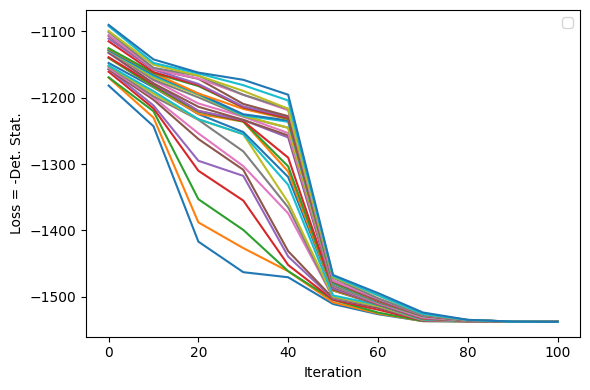

In [9]:
# plot the loss as a function of iteration for different walkers
plt.figure(figsize=(6, 4))
iterations = np.arange(len(optimization_log['best_loss']))*save_step
plt.plot(iterations, optimization_log['best_loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss = -Det. Stat.')
plt.legend()
plt.tight_layout()
plt.savefig(output_dir + '/loss_curve.png', dpi=300)

<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\d'
/var/folders/78/stbtx34d7vj939lq8bmh39wrx379gb/T/ipykernel_29085/4022593453.py:38: SyntaxWarning: invalid escape sequence '\d'
  ax.set_ylabel('Initial Frequency Derivative $\dot{f}_0$ [Hz/s]')


Animation saved to ./quick_start_results/optimization_animation.gif


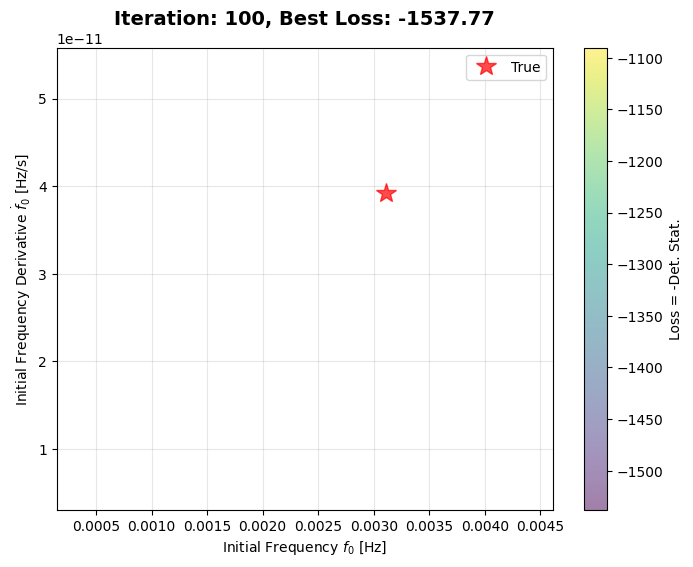

In [10]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Create animation of f vs fdot scatter plot colored by loss
fig, ax = plt.subplots(figsize=(8, 6))

# Get the true f and fdot for reference
f_true = f_alpha[:len(t_alpha)]
fdot_true = np.gradient(f_true, t_alpha)

# Determine global limits for consistent axes
all_f0 = []
all_fdot0 = []
all_losses = []

for iteration_tracks, iteration_losses in zip(optimization_log['best_f'], optimization_log['best_loss']):
    for track, loss in zip(iteration_tracks, iteration_losses):
        track_array = np.array(track)
        fdot_track = np.gradient(track_array, t_alpha)
        all_f0.append(track_array[0])
        all_fdot0.append(fdot_track[0])
        all_losses.append(loss)

f0_min, f0_max = min(all_f0), max(all_f0)
fdot0_min, fdot0_max = min(all_fdot0), max(all_fdot0)
loss_min, loss_max = min(all_losses), max(all_losses)

# Plot true track as reference
ax.plot(f_true[0], fdot_true[0], 'r*', markersize=15, label='True', zorder=10, alpha=0.7)
# ax.axhline(y=fdot_true[0], color='red', linestyle='--', alpha=0.7, label='True $\dot{f}_0$')
# ax.axvline(x=f_true[0], color='red', linestyle='--', alpha=0.7, label='True $f_0$')

scatter = ax.scatter([], [], c=[], cmap='viridis', s=100, alpha=0.5, 
                     vmin=loss_min, vmax=loss_max, edgecolors='black', linewidths=0.5)
colorbar = plt.colorbar(scatter, ax=ax, label='Loss = -Det. Stat.')

ax.set_xlabel('Initial Frequency $f_0$ [Hz]')
ax.set_ylabel('Initial Frequency Derivative $\dot{f}_0$ [Hz/s]')
# Set wider limits with padding for better visualization
padding_x = (f0_max - f0_min) * 0.1
padding_y = (fdot0_max - fdot0_min) * 0.1
ax.set_xlim(f0_min - padding_x, f0_max + padding_x)
ax.set_ylim(fdot0_min - padding_y, fdot0_max + padding_y)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

title = ax.text(0.5, 1.05, '', transform=ax.transAxes, ha='center', fontsize=14, weight='bold')

def init():
    scatter.set_offsets(np.empty((0, 2)))
    scatter.set_array(np.array([]))
    return scatter, title

def update(frame):
    iteration_tracks = optimization_log['best_f'][frame]
    iteration_losses = optimization_log['best_loss'][frame]
    
    f0_values = []
    fdot0_values = []
    loss_values = []
    
    for track, loss in zip(iteration_tracks, iteration_losses):
        track_array = np.array(track)
        fdot_track = np.gradient(track_array, t_alpha)
        f0_values.append(track_array[0])
        fdot0_values.append(fdot_track[0])
        loss_values.append(loss)
    
    points = np.column_stack([f0_values, fdot0_values])
    scatter.set_offsets(points)
    scatter.set_array(np.array(loss_values))
    
    # Update axis limits adaptively for this frame
    f0_frame_min, f0_frame_max = min(f0_values), max(f0_values)
    fdot0_frame_min, fdot0_frame_max = min(fdot0_values), max(fdot0_values)
    
    # Add padding for better visualization
    padding_x = (f0_frame_max - f0_frame_min) * 0.15
    padding_y = (fdot0_frame_max - fdot0_frame_min) * 0.15
    
    # Ensure minimum padding if range is very small
    padding_x = max(padding_x, 1e-5)
    padding_y = max(padding_y, 1e-13)
    
    # ax.set_xlim(f0_frame_min - padding_x, f0_frame_max + padding_x)
    # ax.set_ylim(fdot0_frame_min - padding_y, fdot0_frame_max + padding_y)
    
    title.set_text(f'Iteration: {frame * save_step}, Best Loss: {min(loss_values):.2f}')
    
    return scatter, title, ax

num_frames = len(optimization_log['best_f'])
anim = FuncAnimation(fig, update, frames=num_frames, init_func=init, 
                     blit=False, interval=500, repeat=True)

# Save animation
anim.save(output_dir + '/optimization_animation.gif', writer='pillow', fps=2, dpi=100)
print(f'Animation saved to {output_dir}/optimization_animation.gif')

# Display in notebook
HTML(anim.to_jshtml())

Two-panel frequency evolution animation saved to ./quick_start_results/frequency_evolution_2panel_animation.gif


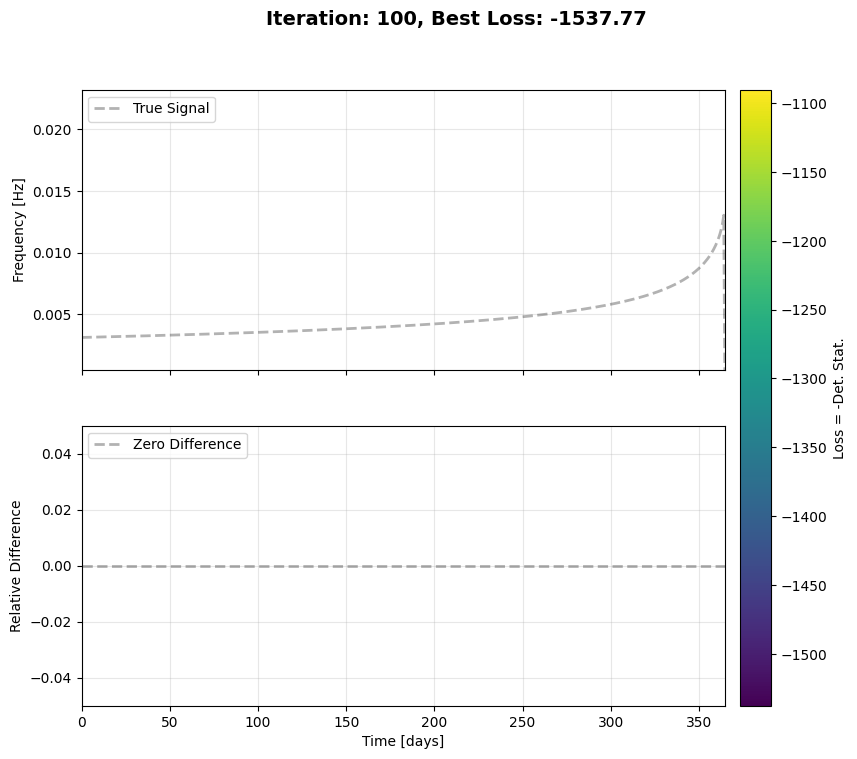

In [ ]:
# Create animation with two subplots: frequency and relative difference
fig2, (ax2_top, ax2_bottom) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Get global limits for fixed axes
all_f_tracks = []
all_rel_diff = []
for iteration_tracks in optimization_log['best_f']:
    for track in iteration_tracks:
        track_array = np.array(track)
        all_f_tracks.extend(track_array)
        rel_diff = ((track_array - f_true) / f_true) 
        all_rel_diff.extend(rel_diff)

f_min, f_max = min(all_f_tracks), max(all_f_tracks)
rel_diff_min, rel_diff_max = min(all_rel_diff), max(all_rel_diff)
t_min, t_max = t_alpha[0] / 86400, t_alpha[-1] / 86400

# Top subplot: Frequency evolution
ax2_top.plot(t_alpha / 86400, f_true, 'k--', linewidth=2, label='True Signal', zorder=10, alpha=0.3)
lines_top = []
for i in range(5):
    line, = ax2_top.plot([], [], alpha=0.7, linewidth=2)
    lines_top.append(line)

ax2_top.set_ylabel('Frequency [Hz]')
ax2_top.set_xlim(t_min, t_max)
ax2_top.set_ylim(f_min * 0.95, f_max * 1.05)
ax2_top.legend(loc='upper left')
ax2_top.grid(True, alpha=0.3)

# Bottom subplot: Relative difference
ax2_bottom.axhline(0, color='k', linestyle='--', linewidth=2, label='Zero Difference', zorder=10, alpha=0.3)
lines_bottom = []
for i in range(5):
    line, = ax2_bottom.plot([], [], alpha=0.7, linewidth=2)
    lines_bottom.append(line)

ax2_bottom.set_xlabel('Time [days]')
ax2_bottom.set_ylabel('Relative Difference')
ax2_bottom.set_xlim(t_min, t_max)
ax2_bottom.set_ylim(rel_diff_min * 1.1, rel_diff_max * 1.1)
ax2_bottom.legend(loc='upper left')
ax2_bottom.grid(True, alpha=0.3)
# ax2_bottom.set_yscale('log')
ax2_bottom.set_ylim(1e-6, rel_diff_max * 1.1)

# Create colormap normalization
norm = plt.Normalize(vmin=loss_min, vmax=loss_max)
cmap = plt.cm.viridis

# Add shared colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig2.colorbar(sm, ax=[ax2_top, ax2_bottom], label='Loss = -Det. Stat.', pad=0.02)

title2 = fig2.suptitle('', fontsize=14, weight='bold')

def init2():
    for line in lines_top + lines_bottom:
        line.set_data([], [])
    return lines_top + lines_bottom + [title2]

def update2(frame):
    iteration_tracks = optimization_log['best_f'][frame]
    iteration_losses = optimization_log['best_loss'][frame]
    
    # Update each track in both subplots
    for i, (track, loss) in enumerate(zip(iteration_tracks, iteration_losses)):
        if i < len(lines_top):
            track_array = np.array(track)
            color = cmap(norm(loss))
            
            # Top subplot: absolute frequency
            lines_top[i].set_data(t_alpha / 86400, track_array)
            lines_top[i].set_color(color)
            lines_top[i].set_alpha(0.7)
            
            # Bottom subplot: relative difference
            rel_diff = (track_array - f_true) / f_true
            lines_bottom[i].set_data(t_alpha / 86400, rel_diff)
            lines_bottom[i].set_color(color)
            lines_bottom[i].set_alpha(0.7)
    
    # Hide unused lines
    for i in range(len(iteration_tracks), len(lines_top)):
        lines_top[i].set_data([], [])
        lines_bottom[i].set_data([], [])
    
    title2.set_text(f'Iteration: {frame * save_step}, Best Loss: {min(iteration_losses):.2f}')
    
    return lines_top + lines_bottom + [title2]

num_frames2 = len(optimization_log['best_f'])
anim2 = FuncAnimation(fig2, update2, frames=num_frames2, init_func=init2, 
                     blit=False, interval=500, repeat=True)

# Save animation
anim2.save(output_dir + '/frequency_evolution_2panel_animation.gif', writer='pillow', fps=2, dpi=100)
print(f'Two-panel frequency evolution animation saved to {output_dir}/frequency_evolution_2panel_animation.gif')

# Display in notebook
HTML(anim2.to_jshtml())

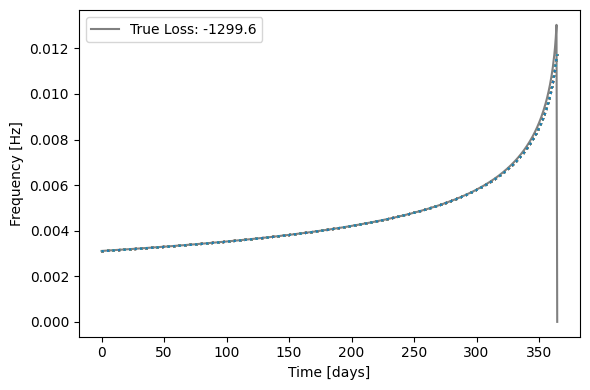

In [ ]:
plt.figure(figsize=(6, 4))
cmap = plt.get_cmap('turbo')
norm = plt.Normalize(vmin=np.min(optimization_log['best_loss'][-1]), vmax=np.max(optimization_log['best_loss'][-1]))
plt.plot(t_alpha/86400, f_alpha[:len(t_alpha)], 'grey', label=f'True Loss: {nll_true:.1f}')
for track, loss in zip(optimization_log['best_f'][-1], optimization_log['best_loss'][-1]):
    plt.plot(t_alpha/86400, track, ':')
plt.legend()
plt.xlabel('Time [days]')
plt.ylabel('Frequency [Hz]')
plt.tight_layout()
plt.savefig(output_dir + '/optimized_frequency_track.png', dpi=300)

/var/folders/78/stbtx34d7vj939lq8bmh39wrx379gb/T/ipykernel_29085/3972425139.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


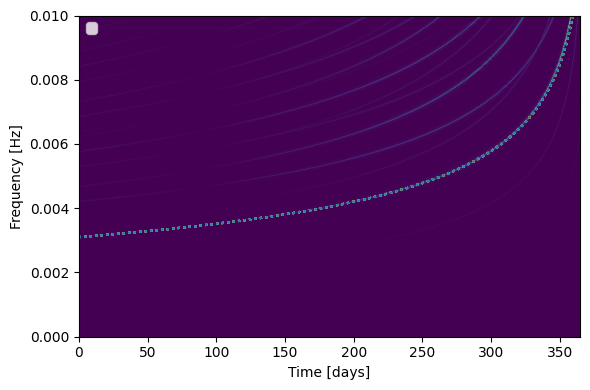

In [ ]:
plt.figure(figsize=(6, 4))
plt.imshow(np.abs(signal_sfts), aspect='auto', origin='lower',
           extent=[0, t_alpha[-1]/86400, frequencies[0], frequencies[-1]], cmap='viridis')
plt.ylim(0.0, 0.01)
cmap = plt.get_cmap('inferno')
norm = plt.Normalize(vmin=np.min(optimization_log['best_loss'][-1]), vmax=np.max(optimization_log['best_loss'][-1]))
for track, loss in zip(optimization_log['best_f'][-1], optimization_log['best_loss'][-1]):
    plt.plot(t_alpha/86400, track, ':')
plt.xlabel('Time [days]')
plt.ylabel('Frequency [Hz]')
plt.tight_layout()
plt.savefig(output_dir + '/optimized_frequency_track.png', dpi=300)

In [14]:
f_alpha = np.asarray(optimization_log['best_f'][-1][-1])
fdot_alpha = np.gradient(f_alpha, t_alpha)
fddot_alpha = np.gradient(fdot_alpha, t_alpha)
delta_phi_approx = np.abs(fddot_alpha * T_sft**3 / 6)
A_alpha = np.where((f_alpha > 10**(-3.5)) & (fdot_alpha > 1e-13) & (delta_phi_approx < 1.0), 1.0, 0.0)
phi_alpha = np.ones_like(f_alpha)

mfilter_hh = injection_dict['m_hh']
mfilter_dh = np.abs(injection_dict['m_hd'])**2/(mfilter_hh)

dh, hh = det_stat_evolution(np.asarray(data_sfts), A_alpha, phi_alpha, f_alpha, fdot_alpha, T_sft=T_sft)
S_data = np.abs(dh)**2 / hh

dh, hh = det_stat_evolution(np.asarray(signal_sfts), A_alpha, phi_alpha, f_alpha, fdot_alpha, T_sft=T_sft)
S_signal = np.abs(dh)**2 / hh


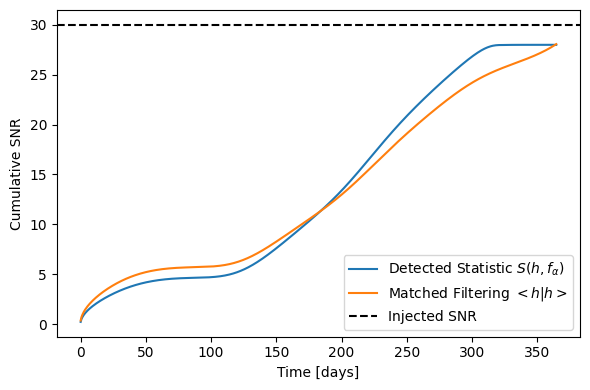

In [15]:
plt.figure(figsize=(6, 4))
plt.plot(t_alpha/86400, np.cumsum(S_signal)**0.5, label='Detected Statistic $S(h,f_\\alpha)$')
plt.plot(t_alpha/86400, np.cumsum(mfilter_hh)**0.5, label='Matched Filtering $<h|h>$')
plt.axhline(snr_ref, color='k', linestyle='--', label='Injected SNR')
plt.xlabel('Time [days]')
plt.ylabel('Cumulative SNR')
plt.legend()
plt.tight_layout()
plt.savefig(output_dir + '/det_stat_evolution.png', dpi=300)


(5001, 631)


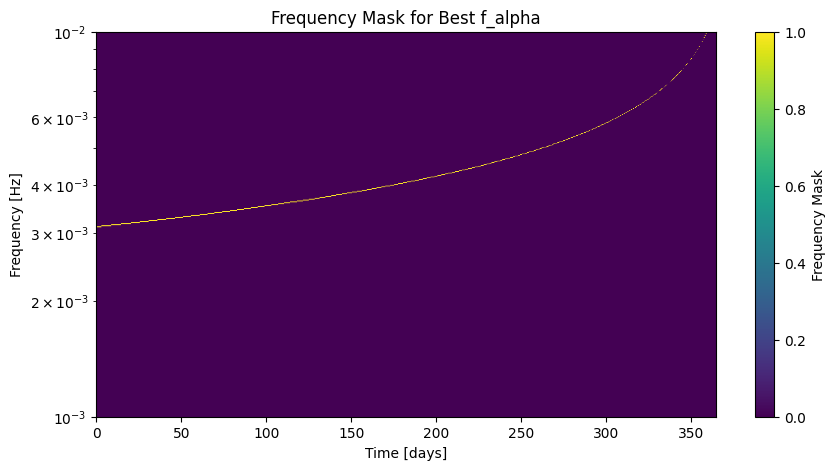

In [16]:
# Efficient vectorized version of freq_pixels assignment
freq_pixels = np.zeros_like(data_sfts, dtype=int)
print(freq_pixels.shape)
num_sfts = injection_dict['num_sfts']

def get_freq_pixels(f_alpha, T_sft, freq_pixels_shape, num_sfts):
    freq_pixels = np.zeros(freq_pixels_shape, dtype=int)
    ind_f = np.asarray(np.round(np.array(f_alpha) * T_sft), dtype=int)
    ind_time = np.arange(num_sfts)
    valid = (ind_f > 0) & (ind_f < freq_pixels_shape[0] - 1)
    ind_f = ind_f[valid]
    ind_time = ind_time[valid]
    freq_pixels[ind_f, ind_time] += 1
    # freq_pixels[ind_f - 1, ind_time] += 1
    # freq_pixels[ind_f + 1, ind_time] += 1
    return freq_pixels

freq_pixels = get_freq_pixels(f_alpha, T_sft, freq_pixels.shape, num_sfts)

plt.figure(figsize=(10, 5))
plt.imshow(freq_pixels, aspect='auto', origin='lower',
           extent=[0, t_alpha[-1]/86400, frequencies[0], frequencies[-1]], cmap='viridis')
plt.ylim(1e-3, 0.01)
plt.yscale('log')
plt.colorbar(label='Frequency Mask')
plt.xlabel('Time [days]')
plt.ylabel('Frequency [Hz]')
plt.title('Frequency Mask for Best f_alpha')
plt.savefig(output_dir + '/frequency_mask.png', dpi=300)
plt.show()


/var/folders/78/stbtx34d7vj939lq8bmh39wrx379gb/T/ipykernel_29085/3302456254.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


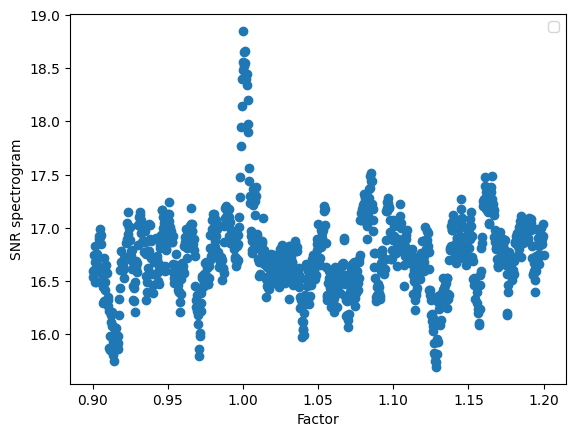

In [17]:
whitened_data = np.array(data_sfts) / np.array(psd(frequencies))[:,None]**0.5 * np.sqrt(frequencies[1]-frequencies[0])
factor_v = np.linspace(0.9, 1.2, 1000)
new_snr = [(np.abs(whitened_data[np.array(get_freq_pixels(factor * f_alpha, T_sft, freq_pixels.shape, num_sfts),dtype=bool)])**2).sum()**0.5 for factor in factor_v]

plt.figure()
plt.plot(factor_v, new_snr, 'o')
plt.xlabel('Factor')
plt.ylabel('SNR spectrogram')
plt.legend()
plt.show()

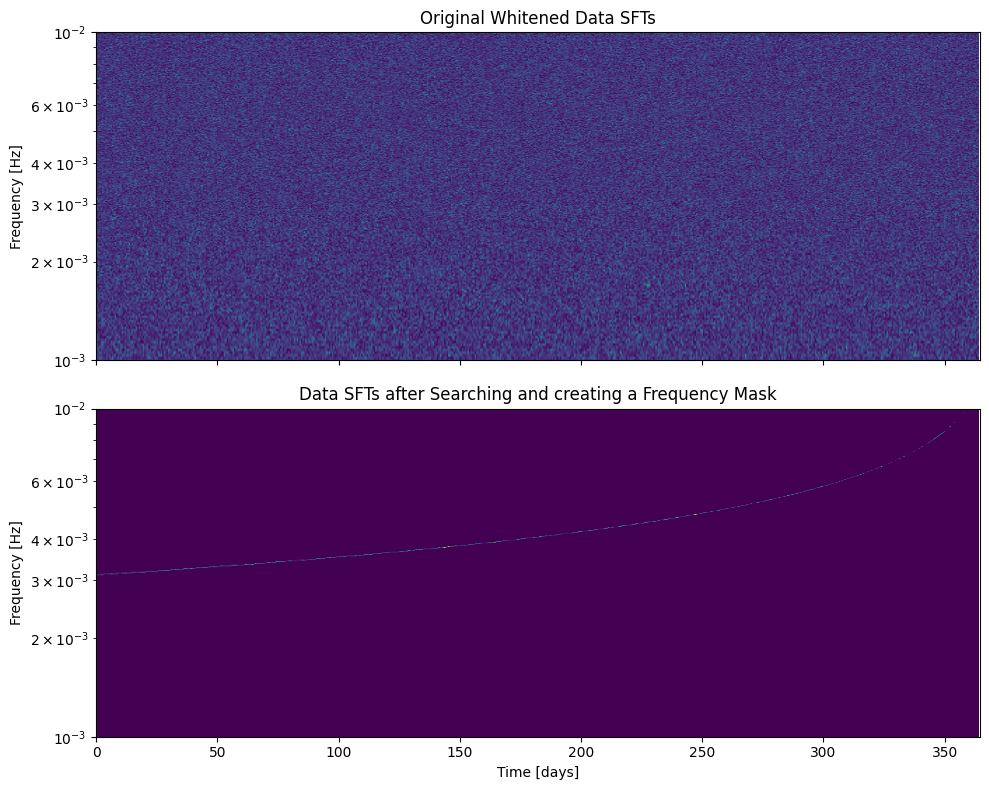

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# First subplot: Original data SFTs
mask_data = freq_pixels > 0
toplot_original = np.array(data_sfts) / np.array(psd(frequencies))[:,None]**0.5

im1 = ax1.imshow(np.abs(toplot_original), aspect='auto', origin='lower',
                 extent=[0, t_alpha[-1]/86400, frequencies[0], frequencies[-1]], cmap='viridis')
ax1.set_ylim(1e-3, 0.01)
ax1.set_yscale('log')
ax1.set_ylabel('Frequency [Hz]')
ax1.set_title('Original Whitened Data SFTs')

# Second subplot: Data SFTs after applying frequency mask
toplot_masked = toplot_original.copy()
toplot_masked[~mask_data] = 0.0

im2 = ax2.imshow(np.abs(toplot_masked), aspect='auto', origin='lower',
                 extent=[0, t_alpha[-1]/86400, frequencies[0], frequencies[-1]], cmap='viridis')
ax2.set_ylim(1e-3, 0.01)
ax2.set_yscale('log')
ax2.set_ylabel('Frequency [Hz]')
ax2.set_xlabel('Time [days]')
ax2.set_title('Data SFTs after Searching and creating a Frequency Mask')

plt.tight_layout()
plt.savefig(output_dir + '/data_comparison.png', dpi=300)
plt.show()


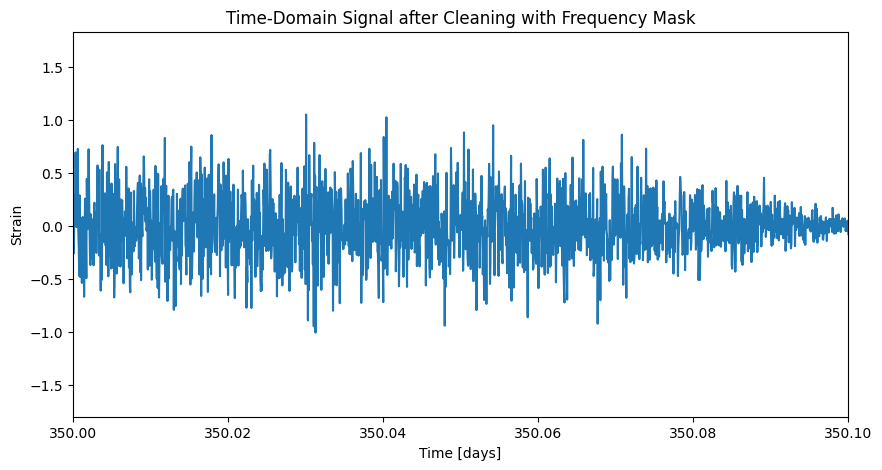

In [19]:
td_signal_cleaned = np.fft.irfft(toplot, axis=0).T.flatten() / deltaT
plt.figure(figsize=(10, 5))
plt.plot(np.arange(td_signal_cleaned.shape[0]) * deltaT / 86400, td_signal_cleaned)
plt.xlim(350, 350.1)
plt.xlabel('Time [days]')
plt.ylabel('Strain')
plt.title('Time-Domain Signal after Cleaning with Frequency Mask')
plt.show()

## Conclusion

This notebook provides a quick start for searching an EMRI signal using a simplified approach. The optimized frequency tracks should closely match the true track, as shown in the final plot. To further reduce computational cost, you can decrease `nsteps` or `batch_size`. For a more comprehensive search, consider searching through all `Tpl` and using a larger prior for the initial frequency of the harmonics.